In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

from sklearn.cluster import KMeans
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import mean_squared_error


import gc, os, random
from collections import Counter, defaultdict
from sklearn.model_selection._split import _BaseKFold
from sklearn.utils.validation import check_random_state

import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow.keras.layers as L


seed = 16
cv_seed = 21041999  #not_my_birthday

def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.random.set_seed(seed)
    
seed_everything(seed)

/opt/conda/lib/python3.7/site-packages/tensorflow_addons/utils/ensure_tf_install.py:68: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.2.0 and strictly below 2.3.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.3.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  UserWarning,


In [2]:
class StratifiedGroupKFold(_BaseKFold):
    """Stratified K-Folds iterator variant with non-overlapping groups.

    This cross-validation object is a variation of StratifiedKFold that returns
    stratified folds with non-overlapping groups. The folds are made by
    preserving the percentage of samples for each class.

    The same group will not appear in two different folds (the number of
    distinct groups has to be at least equal to the number of folds).

    The difference between GroupKFold and StratifiedGroupKFold is that
    the former attempts to create balanced folds such that the number of
    distinct groups is approximately the same in each fold, whereas
    StratifiedGroupKFold attempts to create folds which preserve the
    percentage of samples for each class.

    Read more in the :ref:`User Guide <cross_validation>`.

    Parameters
    ----------
    n_splits : int, default=5
        Number of folds. Must be at least 2.

    shuffle : bool, default=False
        Whether to shuffle each class's samples before splitting into batches.
        Note that the samples within each split will not be shuffled.

    random_state : int or RandomState instance, default=None
        When `shuffle` is True, `random_state` affects the ordering of the
        indices, which controls the randomness of each fold for each class.
        Otherwise, leave `random_state` as `None`.
        Pass an int for reproducible output across multiple function calls.
        See :term:`Glossary <random_state>`.

    Examples
    --------
    >>> import numpy as np
    >>> from sklearn.model_selection import StratifiedGroupKFold
    >>> X = np.ones((17, 2))
    >>> y = np.array([0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0])
    >>> groups = np.array([1, 1, 2, 2, 3, 3, 3, 4, 5, 5, 5, 5, 6, 6, 7, 8, 8])
    >>> cv = StratifiedGroupKFold(n_splits=3)
    >>> for train_idxs, test_idxs in cv.split(X, y, groups):
    ...     print("TRAIN:", groups[train_idxs])
    ...     print("      ", y[train_idxs])
    ...     print(" TEST:", groups[test_idxs])
    ...     print("      ", y[test_idxs])
    TRAIN: [2 2 4 5 5 5 5 6 6 7]
           [1 1 1 0 0 0 0 0 0 0]
     TEST: [1 1 3 3 3 8 8]
           [0 0 1 1 1 0 0]
    TRAIN: [1 1 3 3 3 4 5 5 5 5 8 8]
           [0 0 1 1 1 1 0 0 0 0 0 0]
     TEST: [2 2 6 6 7]
           [1 1 0 0 0]
    TRAIN: [1 1 2 2 3 3 3 6 6 7 8 8]
           [0 0 1 1 1 1 1 0 0 0 0 0]
     TEST: [4 5 5 5 5]
           [1 0 0 0 0]

    See also
    --------
    StratifiedKFold: Takes class information into account to build folds which
        retain class distributions (for binary or multiclass classification
        tasks).

    GroupKFold: K-fold iterator variant with non-overlapping groups.
    """

    def __init__(self, n_splits=5, shuffle=False, random_state=None):
        super().__init__(n_splits=n_splits, shuffle=shuffle,
                         random_state=random_state)

    # Implementation based on this kaggle kernel:
    # https://www.kaggle.com/jakubwasikowski/stratified-group-k-fold-cross-validation
    
    def _iter_test_indices(self, X, y, groups):
        labels_num = np.max(y) + 1
        y_counts_per_group = defaultdict(lambda: np.zeros(labels_num))
        y_distr = Counter()
        for label, group in zip(y, groups):
            y_counts_per_group[group][label] += 1
            y_distr[label] += 1

        y_counts_per_fold = defaultdict(lambda: np.zeros(labels_num))
        groups_per_fold = defaultdict(set)

        groups_and_y_counts = list(y_counts_per_group.items())
        rng = check_random_state(self.random_state)
        if self.shuffle:
            rng.shuffle(groups_and_y_counts)

        for group, y_counts in sorted(groups_and_y_counts,
                                      key=lambda x: -np.std(x[1])):
            best_fold = None
            min_eval = None
            for i in range(self.n_splits):
                y_counts_per_fold[i] += y_counts
                std_per_label = []
                for label in range(labels_num):
                    std_per_label.append(np.std(
                        [y_counts_per_fold[j][label] / y_distr[label]
                         for j in range(self.n_splits)]))
                y_counts_per_fold[i] -= y_counts
                fold_eval = np.mean(std_per_label)
                if min_eval is None or fold_eval < min_eval:
                    min_eval = fold_eval
                    best_fold = i
            y_counts_per_fold[best_fold] += y_counts
            groups_per_fold[best_fold].add(group)

        for i in range(self.n_splits):
            test_indices = [idx for idx, group in enumerate(groups)
                            if group in groups_per_fold[i]]
            yield test_indices

In [3]:
def mean_RMSE(y_true, y_pred, r = 5):
    
    score = 0.0
    y_true = y_true.reshape(-1, 5)
    y_pred = y_pred.reshape(-1, 5)
    
    if(r == 5):
        for i in range(5):
            score += mean_squared_error(y_true[:, i] , y_pred[:, i], squared = False)
        
        return score / 5
    
    for i in [0,1,3]:
        score += mean_squared_error(y_true[:, i] , y_pred[:, i], squared = False)
        
    return score / 3



def MCRMSE(y_true, y_pred):
    
    colwise_mse = tf.reduce_mean(tf.square(y_true - y_pred), axis=1)
    
    return tf.reduce_mean(tf.sqrt(colwise_mse), axis=1)

In [4]:
rna_dict    = {x:i for i, x in enumerate('ACGU')} #4
struct_dict = {x:i for i, x in enumerate('().')} #3 
loop_dict   = {x:i for i, x in enumerate('BEHIMSX')}#7


def bpps_feats(id, c = 1):
    
    bpps_nb_mean = 0.077522 
    bpps_nb_std = 0.08914  

    nb = []
    max_ = []
    std = []
    mean = []

    for mol_id in id.to_list():
        bpps = np.load(f'../input/stanford-covid-vaccine/bpps/{mol_id}.npy')

        max_.append(np.max(bpps, axis = 1))
        std.append(np.std(bpps, axis = 1) * c)
        mean.append(np.mean(bpps, axis = 1) * c)

        bpps_nb = (bpps > 0).sum(axis=0) / bpps.shape[0]
        bpps_nb = (bpps_nb - bpps_nb_mean) / bpps_nb_std
        nb.append(bpps_nb)
        

    return max_, mean, std, nb

def preprocessing(data, c = 1):
    
    
    data['bpps_max'], data['bpps_avg'],   data['bpps_std'], data['bpps_nb']   = bpps_feats(data['id'], c = c)
    
    data['sequence']            = data['sequence'].map(lambda seq: [rna_dict[x] for x in seq])
    data['structure']           = data['structure'].map(lambda seq: [struct_dict[x] for x in seq])
    data['predicted_loop_type'] = data['predicted_loop_type'].map(lambda seq: [loop_dict[x] for x in seq])
    
    return data



def binding(data, seq_length = 107):
    
    a = np.transpose(np.array(data['sequence'].explode()).reshape(-1,seq_length))
    a = tf.one_hot(a, 4).numpy()
    a = np.swapaxes(a, 0, 1)

    b = np.transpose(np.array(data['structure'].explode()).reshape(-1,seq_length))  
    b = tf.one_hot(b, 3).numpy()
    b = np.swapaxes(b, 0, 1)

    c = np.transpose(np.array(data['predicted_loop_type'].explode()).reshape(-1,seq_length))
    c = tf.one_hot(c, 7).numpy()
    c = np.swapaxes(c, 0, 1)
    
    d = np.array(data['bpps_max'].explode()).reshape(-1,seq_length,1)
    e = np.array(data['bpps_avg'].explode()).reshape(-1,seq_length,1)
    f = np.array(data['bpps_std'].explode()).reshape(-1,seq_length,1)
    g = np.array(data['bpps_nb'].explode()).reshape(-1,seq_length,1)
    
    
    return np.array(np.concatenate([a,b,c,d,e,f,g], axis = -1),  dtype=np.float)

In [5]:
aug_df = pd.read_csv('../input/aug-data-0/aug_data.csv')


def aug_data(df):
    
    target_df = df.copy()
    new_df = aug_df[aug_df['id'].isin(target_df['id'])]
                         
    del target_df['structure']
    del target_df['predicted_loop_type']
    
    new_df = new_df.merge(target_df, on=['id','sequence'], how='left')

    df['cnt'] = df['id'].map(new_df[['id','cnt']].set_index('id').to_dict()['cnt'])
    df['log_gamma'] = 100
    df['score'] = 1.0
    df = df.append(new_df[df.columns])
    return df

In [6]:
data = pd.read_json('../input/stanford-covid-vaccine/train.json',lines=True)
test = pd.read_json('../input/stanford-covid-vaccine/test.json',lines=True)


data, test = aug_data(data), aug_data(test)
data, test = preprocessing(data), preprocessing(test)


pred_cols = ['reactivity', 'deg_Mg_pH10','deg_pH10',  'deg_Mg_50C', 'deg_50C']

data.shape, test.shape

((4800, 26), (7268, 14))

In [7]:
kmeans = KMeans(n_clusters = 200, random_state = 31428)
kmeans.fit(np.array(data['sequence'].explode()).reshape(-1, 107))


data['clusters'] = kmeans.labels_

In [8]:
def gru_layer(hidden_dim, dropout):
    
    return L.Bidirectional(L.GRU(hidden_dim,
                                 dropout = dropout, 
                                 return_sequences = True))

def lstm_layer(hidden_dim, dropout):
    
    return L.Bidirectional(L.LSTM(hidden_dim,
                                 dropout = dropout, 
                                 return_sequences = True))


def bulid_model(seq_len=107, pred_len=68, dropout=0.35, embed_dim=75, hidden_dim=128):
    
    inputs = L.Input(shape=(seq_len, 18))#number of features
    
    x = tf.keras.layers.Conv1D(filters = 64, kernel_size = 5, padding = 'same')(inputs)
    x = tf.keras.layers.Conv1D(filters = 128, kernel_size = 1, padding = 'same')(x)

    x = gru_layer(128, 0.25)(x)
    x = gru_layer(256, 0.5)(x)


    truncated = x[:, :pred_len]
    out = L.Dense(5, activation='linear')(truncated)

    
    model = tf.keras.Model(inputs=inputs, outputs=out)
    
    opt = tf.keras.optimizers.Adam(learning_rate = 0.001)
    
    model.compile(optimizer  = opt, loss=MCRMSE)
    
    
    return model

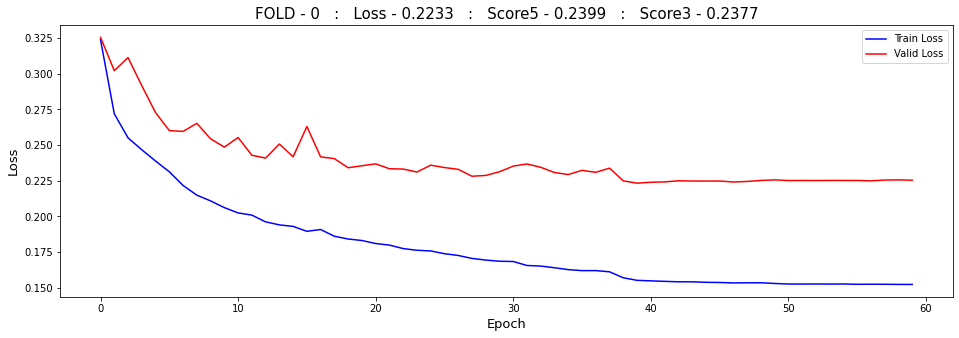

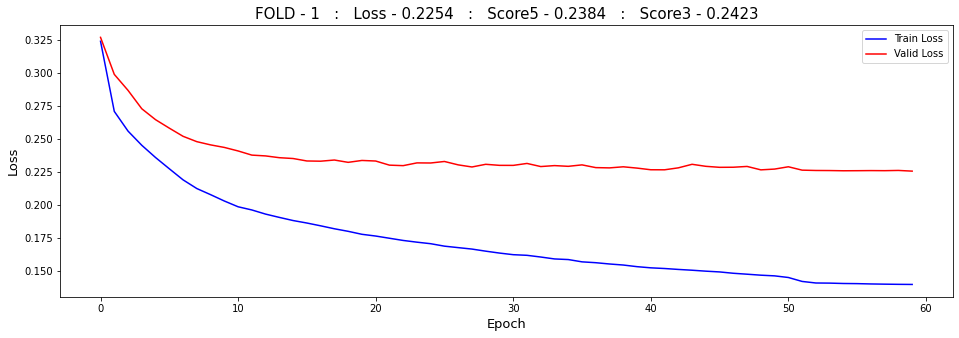

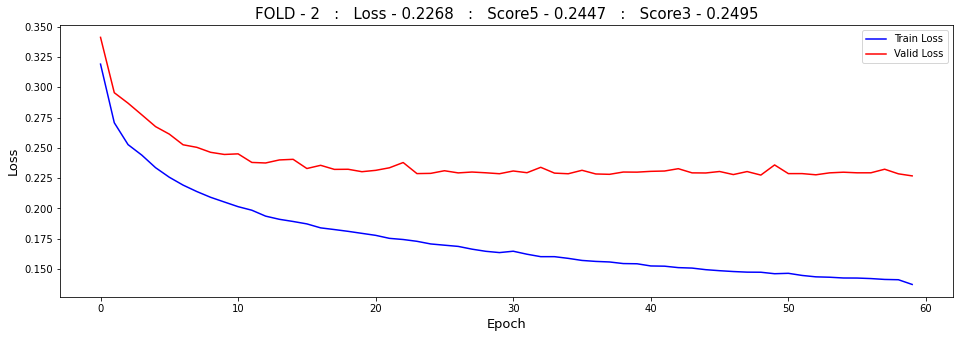

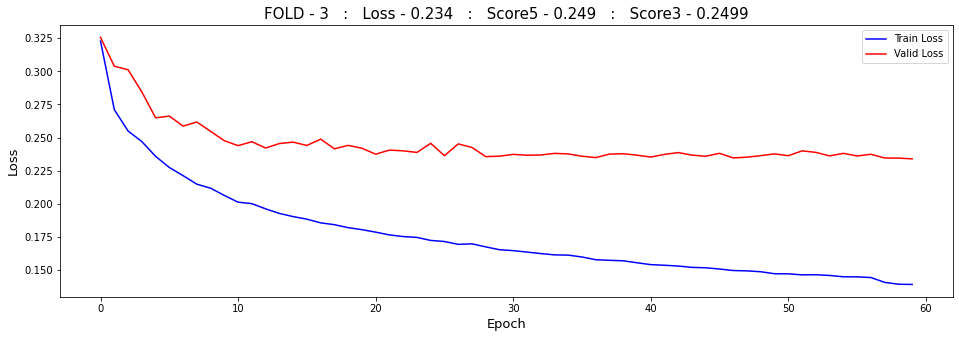

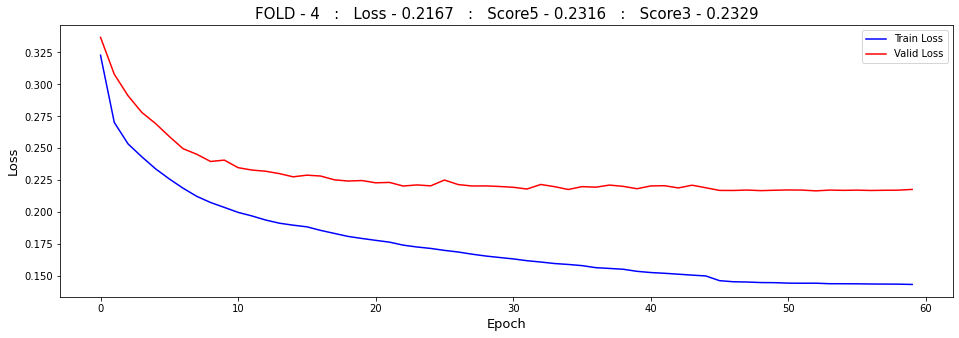

In [9]:
folds = 5
cv = StratifiedGroupKFold(n_splits = folds, shuffle = True, random_state = cv_seed)


data_pred = np.zeros((data.shape[0], 68, len(pred_cols)))


fold_scores5 = []
fold_scores3 = []
fold_loss = []

sn_filter_labels = []
sn_filter_preds = []

for fold_index, (train_index, valid_index) in enumerate(cv.split(data, data['SN_filter'], data['clusters'])):
    
    train = data.iloc[train_index]
    valid = data.iloc[valid_index]

    train_inputs = binding(train)
    valid_inputs = binding(valid)
    
    
    train_labels = np.array(train[pred_cols].values.tolist()).transpose((0, 2, 1))
    valid_labels = np.array(valid[pred_cols].values.tolist()).transpose((0, 2, 1))
    
    
    
    sn_filter = valid[valid.SN_filter == 1]
    sn_inputs = binding(sn_filter)
    sn_labels = np.array(sn_filter[pred_cols].values.tolist()).transpose((0, 2, 1))
    
    
    sample_weight = np.log(train['signal_to_noise'] + 1.1) / 2

    model = bulid_model()
    
    
    model_name = str(fold_index) + '.h5'
    lr_schdler = tf.keras.callbacks.ReduceLROnPlateau()
    save_model = tf.keras.callbacks.ModelCheckpoint(model_name, save_best_only=True)
    
    history = model.fit(train_inputs, train_labels,
                        validation_data = (sn_inputs, sn_labels),
                        batch_size = 64,
                        epochs = 60,
                        sample_weight = sample_weight,
                        callbacks = [lr_schdler, save_model],
                        verbose = 0)
    
    model.load_weights(model_name)
    
    
    valid_pred = model.predict(valid_inputs)
    data_pred[valid_index, :, : ] = valid_pred
    
    sn_preds = model.predict(sn_inputs)
    sn_filter_preds.append(sn_preds)
    sn_filter_labels.append(sn_labels)
    
    
    score5 = mean_RMSE(sn_labels, sn_preds, r=5)
    fold_scores5.append(score5)
    
    score3 = mean_RMSE(sn_labels, sn_preds, r=3)
    fold_scores3.append(score3)
    
    loss = np.min(history.history['val_loss'])
    fold_loss.append(loss)
    
    del model
    del train, valid
    del train_inputs, valid_inputs
    del train_labels, valid_labels
    del sn_filter, sn_inputs, sn_labels
    
    
    plt.figure(figsize=(16,5))
    
    plt.plot(np.clip(history.history['loss'], 0, 0.5),label='Train Loss',color='blue')
    plt.plot(np.clip(history.history['val_loss'],0, 0.5),label='Valid Loss',color='red')
    
    plt.legend(loc=1)
    
    plt.title('FOLD - '+str(fold_index)+'   :   '+'Loss - '+str(round(loss, 4))+'   :   '+'Score5 - '+str(round(score5, 4))+'   :   '+'Score3 - '+str(round(score3, 4)),
              size=15)
    
    plt.ylabel('Loss',size=13); plt.xlabel('Epoch',size=13)
    plt.show()

In [10]:
data_labels = np.array(data[pred_cols].values.tolist()).transpose((0, 2, 1))

clean_data_labels = np.concatenate([i for i in sn_filter_labels])
clean_data_pred = np.concatenate([i for i in sn_filter_preds])


print()
print('-'*50)
print()

print('OOF Score5  : ', mean_RMSE(clean_data_labels, clean_data_pred, r=5))
print()
print('OOF Score3  : ', mean_RMSE(clean_data_labels, clean_data_pred, r=3))

print()
print('Mean Score5 : ', np.mean(fold_scores5))
print('STD         : ', round(np.std(fold_scores5), 6))

print()
print('Mean Score3 : ', np.mean(fold_scores3))
print('STD         : ', round(np.std(fold_scores3), 6))

print()
print('Mean Loss   : ', np.mean(fold_loss))
print('STD         : ', round(np.std(fold_loss), 6))

print()
print('-'*50)
print()


--------------------------------------------------

OOF Score5  :  0.24082104661851716

OOF Score3  :  0.24255745520756042

Mean Score5 :  0.2407140747883469
STD         :  0.005889

Mean Score3 :  0.24245921315313645
STD         :  0.006603

Mean Loss   :  0.2252214163541794
STD         :  0.005586

--------------------------------------------------



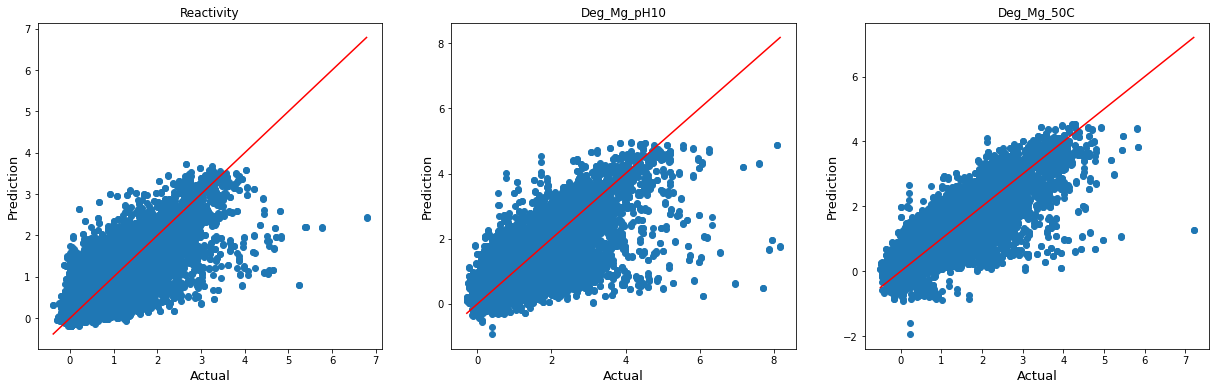

In [11]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(21,6))

min_, max_ = np.min(clean_data_labels.reshape(-1, 5)[:,0]), np.max(clean_data_labels.reshape(-1, 5)[:,0])
ax1.scatter(clean_data_labels.reshape(-1, 5)[:,0], clean_data_pred.reshape(-1, 5)[:,0])
ax1.plot([min_, max_], [min_, max_], color='red')
ax1.set_ylabel('Prediction',size=13); ax1.set_xlabel('Actual',size=13)
ax1.title.set_text('Reactivity')

min_, max_ = np.min(clean_data_labels.reshape(-1, 5)[:,1]), np.max(clean_data_labels.reshape(-1, 5)[:,1])
ax2.scatter(clean_data_labels.reshape(-1, 5)[:,1], clean_data_pred.reshape(-1, 5)[:,1])
ax2.plot([min_, max_], [min_, max_], color='red')
ax2.set_ylabel('Prediction',size=13); ax2.set_xlabel('Actual',size=13)
ax2.title.set_text('Deg_Mg_pH10')

min_, max_ = np.min(clean_data_labels.reshape(-1, 5)[:,3]), np.max(clean_data_labels.reshape(-1, 5)[:,3])
ax3.scatter(clean_data_labels.reshape(-1, 5)[:,3], clean_data_pred.reshape(-1, 5)[:,3])
ax3.plot([min_, max_], [min_, max_], color='red')
ax3.set_ylabel('Prediction',size=13); ax3.set_xlabel('Actual',size=13)
ax3.title.set_text('Deg_Mg_50C')

fig.show()

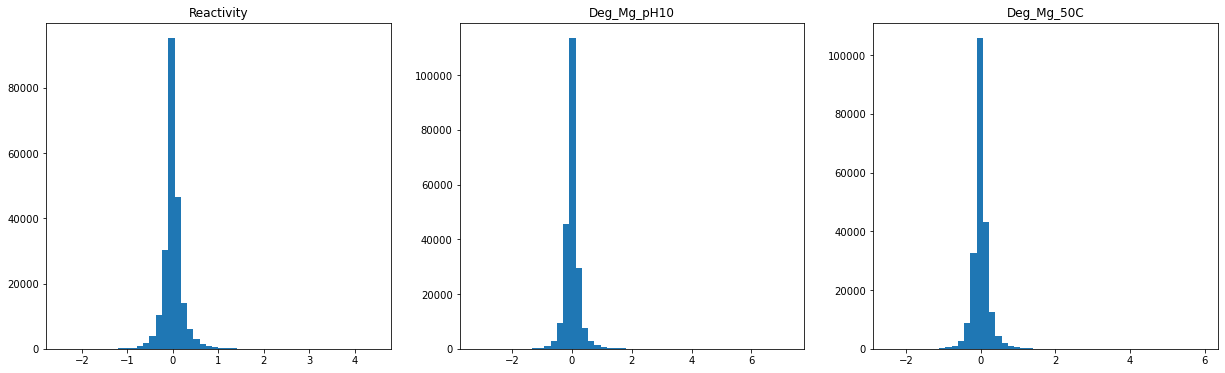

In [12]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(21,6))

ax1.hist(clean_data_labels.reshape(-1, 5)[:,0]-clean_data_pred.reshape(-1, 5)[:,0], bins = 50)
ax1.title.set_text('Reactivity')


ax2.hist(clean_data_labels.reshape(-1, 5)[:,1]-clean_data_pred.reshape(-1, 5)[:,1], bins = 50)
ax2.title.set_text('Deg_Mg_pH10')

ax3.hist(clean_data_labels.reshape(-1, 5)[:,3]-clean_data_pred.reshape(-1, 5)[:,3], bins = 50)
ax3.title.set_text('Deg_Mg_50C')

fig.show()

In [13]:
oof_ls = []

for i, uid in enumerate(data.id):
    
    single_pred = data_pred[i]
    
    single_df = pd.DataFrame(single_pred, columns=pred_cols) 
    single_df['id_seqpos'] = [f'{uid}_{x}' for x in range(single_df.shape[0])]
    
    oof_ls.append(single_df)
    
oof_df = pd.concat(oof_ls).groupby('id_seqpos').mean().reset_index()

oof_df = oof_df.reindex(columns=['id_seqpos', 'reactivity', 'deg_Mg_pH10','deg_pH10',  'deg_Mg_50C', 'deg_50C'])

oof_df.to_csv('oof.csv', index = False)


np.save('data_label.npy', data_labels)
np.save('data_pred.npy', data_pred)

del oof_ls
del data_labels, data_pred

oof_df

id_seqpos  reactivity  deg_Mg_pH10  deg_pH10  deg_Mg_50C  \
0        id_001f94081_0    0.354449     0.610869  1.890074    0.409056   
1        id_001f94081_1    1.665245     2.921142  3.817930    3.162560   
2       id_001f94081_10    0.794235     0.960845  0.663540    1.084186   
3       id_001f94081_11    1.062592     0.652769  0.368327    0.853149   
4       id_001f94081_12    1.353184     1.398259  0.824810    1.449463   
...                 ...         ...          ...       ...         ...   
163195  id_fff546103_66    0.022054     0.286493  0.184080    0.213418   
163196  id_fff546103_67    0.167700     0.485250  0.681400    0.234812   
163197   id_fff546103_7    0.013035     0.119922  0.125595    0.082109   
163198   id_fff546103_8   -0.005421     0.109833  0.096095    0.057060   
163199   id_fff546103_9   -0.058259     0.121119  0.083082    0.062395   

         deg_50C  
0       0.719991  
1       2.747527  
2       1.036137  
3       0.877245  
4       0.940944  
...          ...  
163195  0.135762  
163196  0.431492  
163197  0.118824  
163198  0.031501  
163199 -0.021408  

[163200 rows x 6 columns]

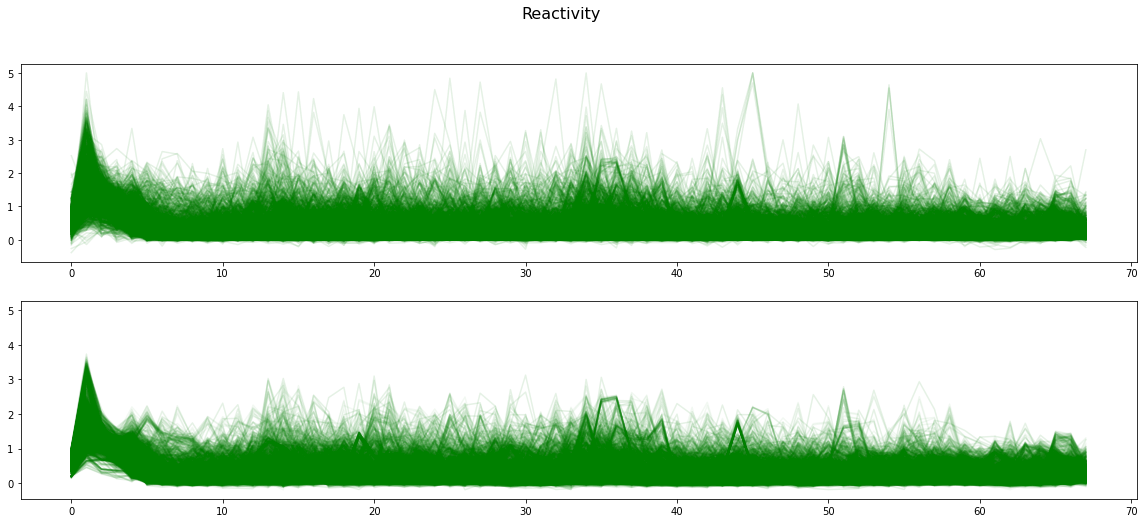

In [14]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20,8))

ax1.plot([0],[5], alpha = 0.0)
for i in range(clean_data_labels.shape[0]):
    ax1.plot(np.clip(clean_data_labels[i, :, 0], -99, 5.0), color = 'green', alpha = 0.05)
    
ax2.plot([0],[5], alpha = 0.0)
for i in range(clean_data_labels.shape[0]):
    ax2.plot(clean_data_pred[i, :, 0], color = 'green', alpha = 0.05)

fig.suptitle("Reactivity", fontsize=16)
fig.show()

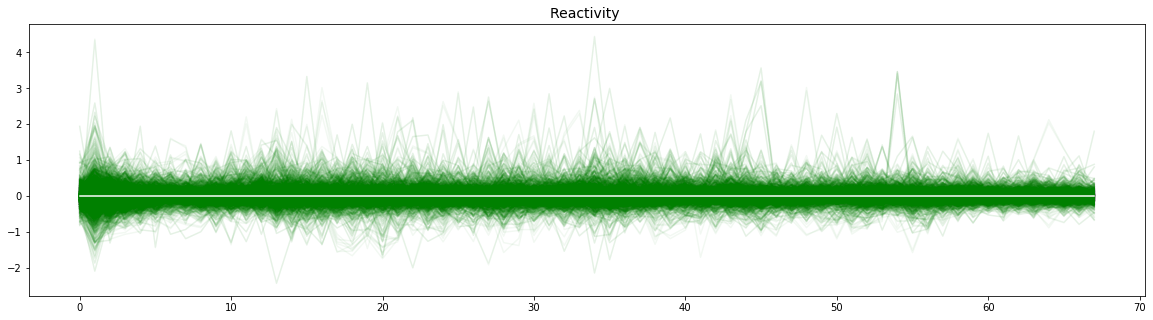

In [15]:
plt.figure(figsize=(20,5))
for i in range(clean_data_labels.shape[0]):
    plt.plot(clean_data_labels[i, :, 0] - clean_data_pred[i, :, 0], color = 'green', alpha = 0.05)
plt.plot([0,67], [0,0], color = 'white')
plt.title('Reactivity ', size = 14)
plt.show()

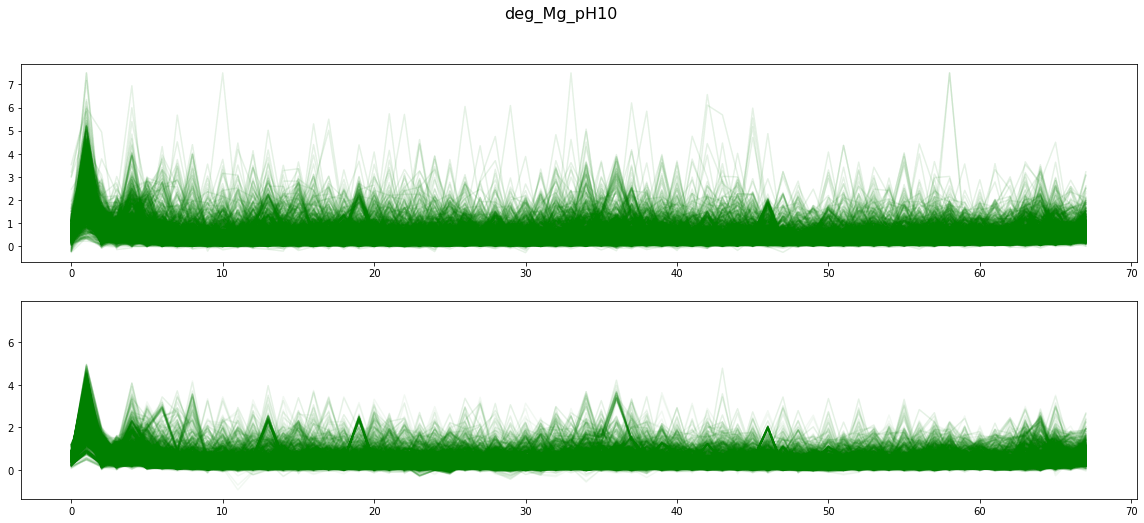

In [16]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20,8))

ax1.plot([0],[7.5], alpha = 0.0)
for i in range(clean_data_labels.shape[0]):
    ax1.plot(np.clip(clean_data_labels[i, :, 1], -99, 7.5), color = 'green', alpha = 0.05)
    
ax2.plot([0],[7.5], alpha = 0.0)
for i in range(clean_data_labels.shape[0]):
    ax2.plot(clean_data_pred[i, :, 1], color = 'green', alpha = 0.05)

fig.suptitle("deg_Mg_pH10", fontsize=16)
fig.show()

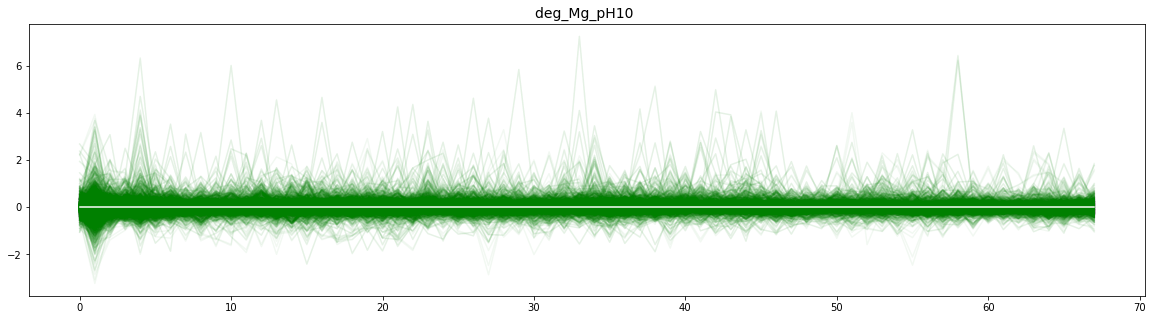

In [17]:
plt.figure(figsize=(20,5))
for i in range(clean_data_labels.shape[0]):
    plt.plot(clean_data_labels[i, :, 1] - clean_data_pred[i, :, 1], color = 'green', alpha = 0.05) 
plt.plot([0,67], [0,0], color = 'white')
plt.title('deg_Mg_pH10 ', size = 14)
plt.show()

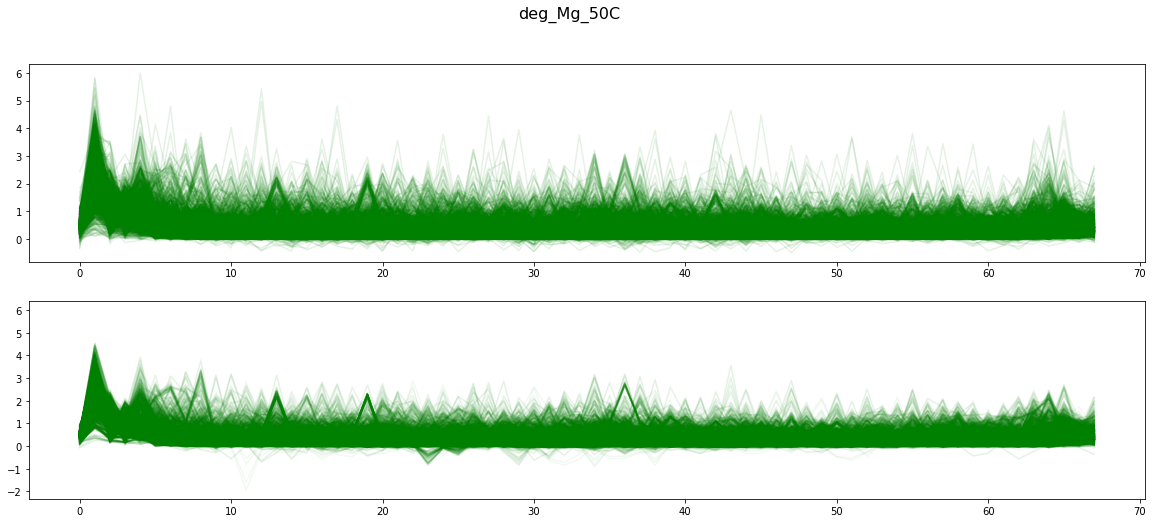

In [18]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20,8))

ax1.plot([0],[6], alpha = 0.0)
for i in range(clean_data_labels.shape[0]):
    ax1.plot(np.clip(clean_data_labels[i, :, 3], -99, 6.0), color = 'green', alpha = 0.05)
    
ax2.plot([0],[6], alpha = 0.0)
for i in range(clean_data_labels.shape[0]):
    ax2.plot(clean_data_pred[i, :, 3], color = 'green', alpha = 0.05)

fig.suptitle("deg_Mg_50C", fontsize=16)
fig.show()

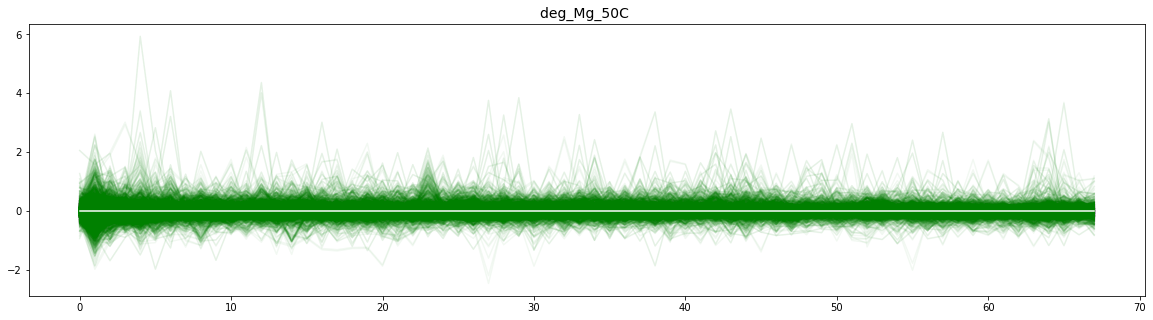

In [19]:
plt.figure(figsize=(20,5))
for i in range(clean_data_labels.shape[0]):
    plt.plot(clean_data_labels[i, :, 3] - clean_data_pred[i, :, 3], color = 'green', alpha = 0.05)
plt.plot([0,67], [0,0], color = 'white')
plt.title('deg_Mg_50C ', size = 14)
plt.show()

In [20]:
 del clean_data_labels, clean_data_pred

In [21]:
public_df = test.query("seq_length == 107").copy()
private_df = test.query("seq_length == 130").copy()

public_inputs = binding(public_df)
private_inputs = binding(private_df, 130)


public_preds = np.zeros((public_df.shape[0], 107, 5))
private_preds = np.zeros((private_df.shape[0], 130, 5))

for i in range(folds):
    model_name = str(i) + '.h5'

    model_short = bulid_model(seq_len=107, pred_len=107)
    model_long  = bulid_model(seq_len=130, pred_len=130)

    model_short.load_weights(model_name)
    model_long.load_weights(model_name)

    public_preds  += (1/folds) * model_short.predict(public_inputs)
    private_preds += (1/folds) * model_long.predict(private_inputs)
    
    del model_short, model_long
    
preds_ls = []

for df, preds in [(public_df, public_preds), (private_df, private_preds)]:
    for i, uid in enumerate(df.id):
        single_pred = preds[i]

        single_df = pd.DataFrame(single_pred, columns=pred_cols)
        single_df['id_seqpos'] = [f'{uid}_{x}' for x in range(single_df.shape[0])]

        preds_ls.append(single_df)

        
preds_df = pd.concat(preds_ls).groupby('id_seqpos').mean().reset_index()


sub1 = pd.read_csv('/kaggle/input/stanford-covid-vaccine/sample_submission.csv')
sub1 = sub1[['id_seqpos']].merge(preds_df, on=['id_seqpos'])
sub1 = sub1.reindex(columns=['id_seqpos','reactivity','deg_Mg_pH10','deg_pH10','deg_Mg_50C','deg_50C'])
sub1.to_csv('sub1.csv', index=False)
sub1

id_seqpos  reactivity  deg_Mg_pH10  deg_pH10  deg_Mg_50C  \
0         id_00073f8be_0    0.636469     0.639775  2.036036    0.514673   
1         id_00073f8be_1    2.021962     2.986648  4.205942    3.027396   
2         id_00073f8be_2    1.456376     0.577879  0.655899    0.641794   
3         id_00073f8be_3    1.245763     1.024913  1.160689    1.537360   
4         id_00073f8be_4    0.849458     0.551099  0.522607    0.839564   
...                  ...         ...          ...       ...         ...   
457948  id_ffda94f24_125    0.079989     0.398485  0.450036    0.513166   
457949  id_ffda94f24_126    0.227249     0.424333  0.582764    0.524575   
457950  id_ffda94f24_127    0.455930     0.093989  0.140373    0.148853   
457951  id_ffda94f24_128    0.148921     0.147953  0.079503    0.214064   
457952  id_ffda94f24_129    0.077908     0.209983  0.142541    0.205096   

         deg_50C  
0       0.768014  
1       2.813948  
2       0.680090  
3       1.714893  
4       0.885013  
...          ...  
457948  0.315711  
457949  0.513375  
457950  0.276131  
457951  0.099630  
457952  0.085852  

[457953 rows x 6 columns]

In [22]:
test = pd.read_json('../input/stanford-covid-vaccine/test.json',lines=True)
test = aug_data(test)
test =  preprocessing(test, c = 1.2149532710280375)

public_df = test.query("seq_length == 107").copy()
private_df = test.query("seq_length == 130").copy()

public_inputs = binding(public_df)
private_inputs = binding(private_df, 130)


public_predsN = np.zeros((public_df.shape[0], 107, 5))
private_predsN = np.zeros((private_df.shape[0], 130, 5))

for i in range(folds):
    model_name = str(i) + '.h5'

    model_short = bulid_model(seq_len=107, pred_len=107)
    model_long  = bulid_model(seq_len=130, pred_len=130)

    model_short.load_weights(model_name)
    model_long.load_weights(model_name)

    public_predsN  += (1/folds) * model_short.predict(public_inputs)
    private_predsN += (1/folds) * model_long.predict(private_inputs)
    
    del model_short, model_long
    
preds_ls = []

for df, preds in [(public_df, public_predsN), (private_df, private_predsN)]:
    for i, uid in enumerate(df.id):
        single_pred = preds[i]

        single_df = pd.DataFrame(single_pred, columns=pred_cols)
        single_df['id_seqpos'] = [f'{uid}_{x}' for x in range(single_df.shape[0])]

        preds_ls.append(single_df)

        
preds_df = pd.concat(preds_ls).groupby('id_seqpos').mean().reset_index()


sub2 = pd.read_csv('/kaggle/input/stanford-covid-vaccine/sample_submission.csv')
sub2 = sub2[['id_seqpos']].merge(preds_df, on=['id_seqpos'])
sub2 = sub2.reindex(columns=['id_seqpos','reactivity','deg_Mg_pH10','deg_pH10','deg_Mg_50C','deg_50C'])
sub2.to_csv('sub2.csv', index=False)
sub2

id_seqpos  reactivity  deg_Mg_pH10  deg_pH10  deg_Mg_50C  \
0         id_00073f8be_0    0.640298     0.641047  2.028003    0.515108   
1         id_00073f8be_1    2.024132     2.995725  4.202278    3.033244   
2         id_00073f8be_2    1.455130     0.579274  0.656541    0.642411   
3         id_00073f8be_3    1.245211     1.029890  1.161516    1.541927   
4         id_00073f8be_4    0.849933     0.553743  0.525100    0.841388   
...                  ...         ...          ...       ...         ...   
457948  id_ffda94f24_125    0.080367     0.399075  0.451420    0.514232   
457949  id_ffda94f24_126    0.227824     0.425006  0.585205    0.526069   
457950  id_ffda94f24_127    0.456702     0.093929  0.141731    0.149216   
457951  id_ffda94f24_128    0.149083     0.148177  0.080617    0.214657   
457952  id_ffda94f24_129    0.078135     0.210599  0.144119    0.206194   

         deg_50C  
0       0.767633  
1       2.813608  
2       0.679056  
3       1.714490  
4       0.886996  
...          ...  
457948  0.316947  
457949  0.515223  
457950  0.277236  
457951  0.100537  
457952  0.087275  

[457953 rows x 6 columns]

In [23]:
np.save('public_preds.npy',public_preds)
np.save('private_preds.npy',private_preds)
np.save('public_predsN.npy', public_predsN)
np.save('private_predsN.npy',private_predsN)

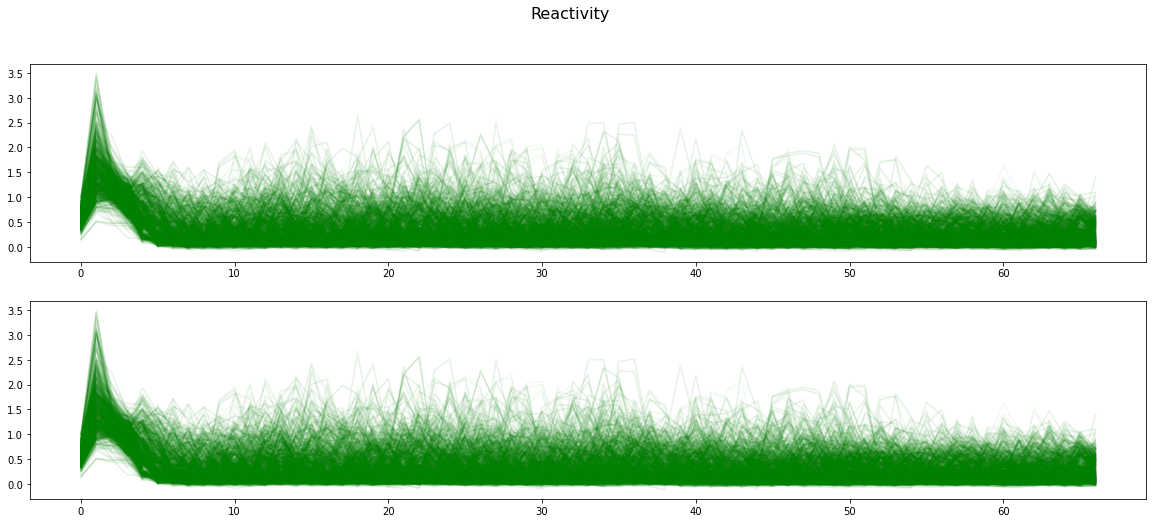

In [24]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20,8))


for i in range(public_preds.shape[0]):
    ax1.plot(np.clip(public_preds[i, : 67, 0], -99, 5.0), color = 'green', alpha = 0.05)
    

for i in range(public_predsN.shape[0]):
    ax2.plot(public_predsN[i, :67, 0], color = 'green', alpha = 0.05)

fig.suptitle("Reactivity", fontsize=16)
fig.show()

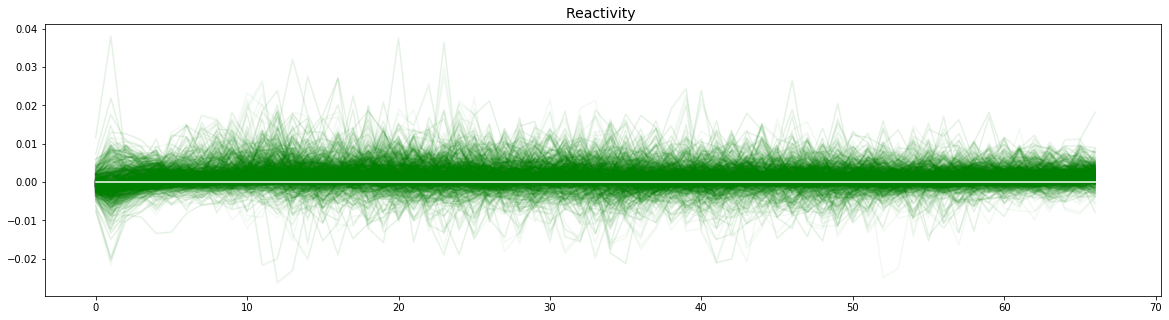

In [25]:
plt.figure(figsize=(20,5))
for i in range(public_preds.shape[0]):
    plt.plot(public_preds[i, :67, 0] - public_predsN[i, :67, 0], color = 'green', alpha = 0.05)
plt.plot([0,67], [0,0], color = 'white')
plt.title('Reactivity ', size = 14)
plt.show()

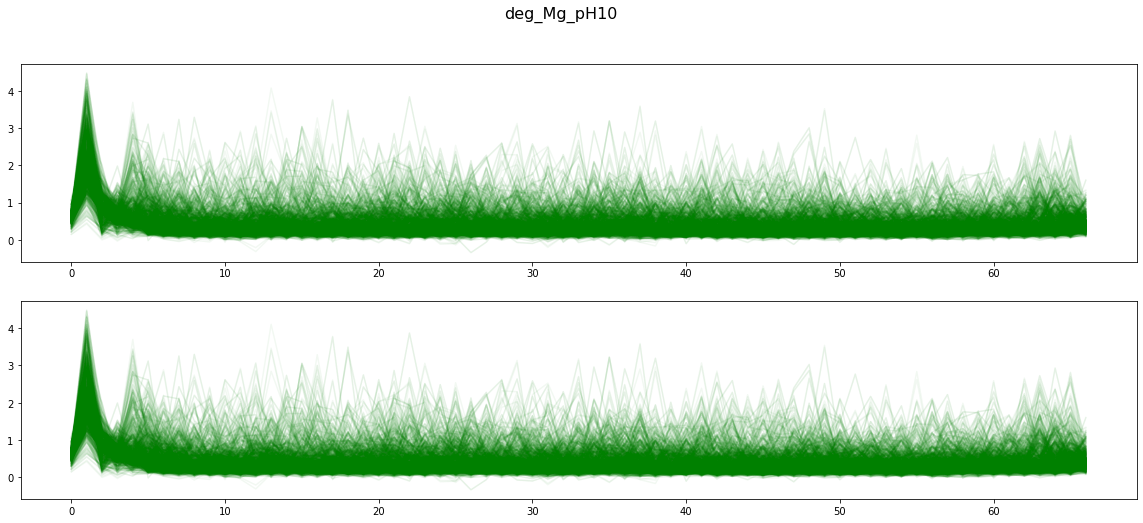

In [26]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20,8))


for i in range(public_preds.shape[0]):
    ax1.plot(np.clip(public_preds[i, :67, 1], -99, 7.5), color = 'green', alpha = 0.05)
    

for i in range(public_preds.shape[0]):
    ax2.plot(public_predsN[i, :67, 1], color = 'green', alpha = 0.05)

fig.suptitle("deg_Mg_pH10", fontsize=16)
fig.show()

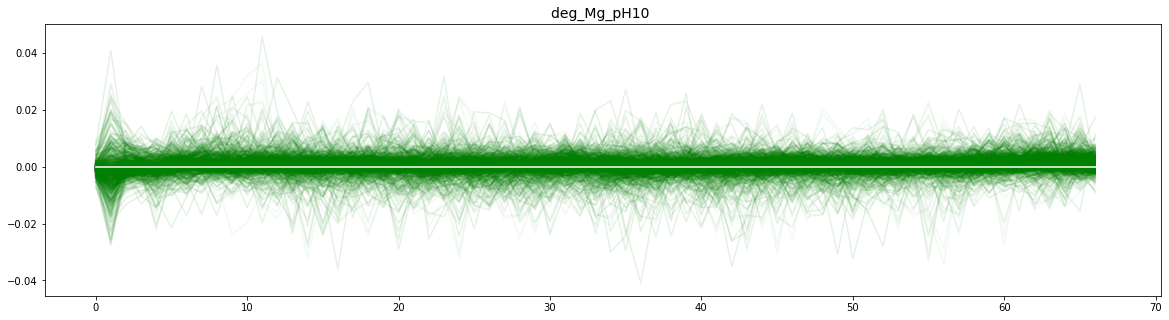

In [27]:
plt.figure(figsize=(20,5))
for i in range(public_preds.shape[0]):
    plt.plot(public_preds[i, :67, 1] - public_predsN[i, :67, 1], color = 'green', alpha = 0.05) 
plt.plot([0,67], [0,0], color = 'white')
plt.title('deg_Mg_pH10 ', size = 14)
plt.show()

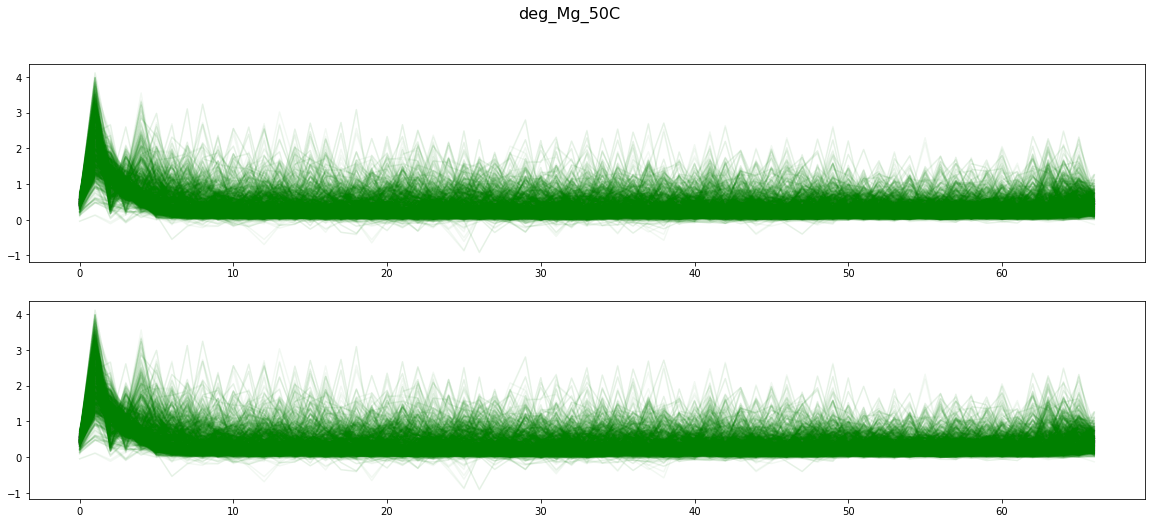

In [28]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20,8))


for i in range(public_preds.shape[0]):
    ax1.plot(np.clip(public_preds[i, :67, 3], -99, 6.0), color = 'green', alpha = 0.05)
    

for i in range(public_predsN.shape[0]):
    ax2.plot(public_predsN[i, :67, 3], color = 'green', alpha = 0.05)

fig.suptitle("deg_Mg_50C", fontsize=16)
fig.show()

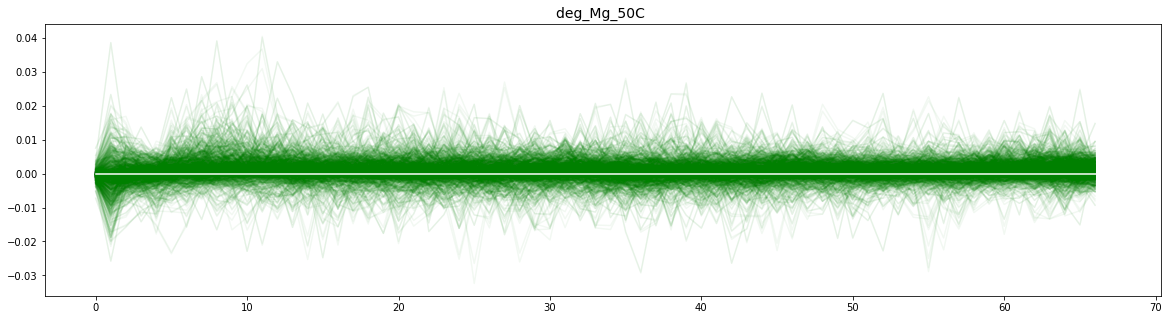

In [29]:
plt.figure(figsize=(20,5))
for i in range(public_preds.shape[0]):
    plt.plot(public_preds[i, :67, 3] - public_predsN[i, :67, 3], color = 'green', alpha = 0.05)
plt.plot([0,67], [0,0], color = 'white')
plt.title('deg_Mg_50C ', size = 14)
plt.show()

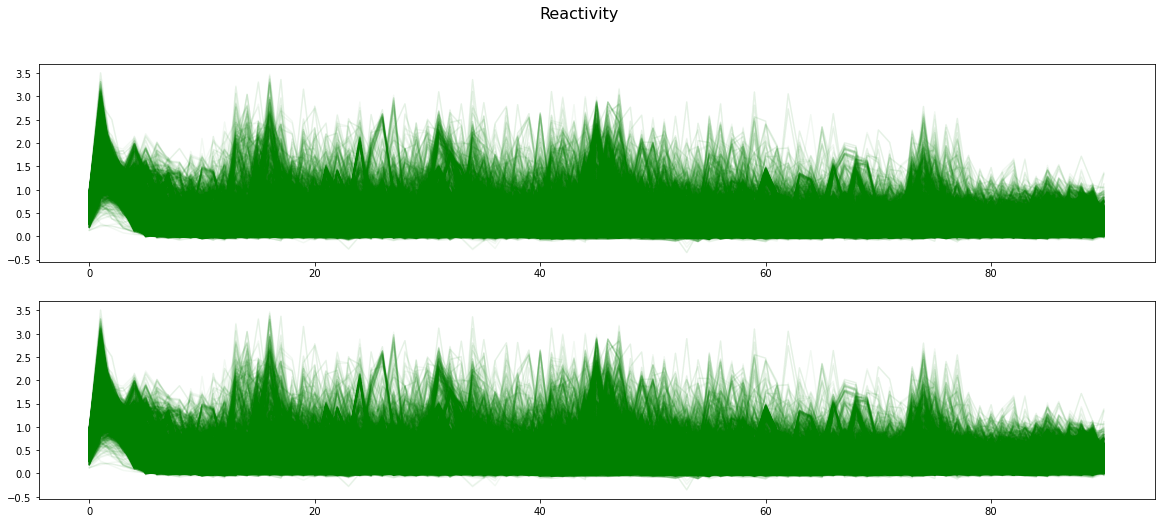

In [30]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20,8))


for i in range(private_preds.shape[0]):
    ax1.plot(np.clip(private_preds[i, :91, 0], -99, 5.0), color = 'green', alpha = 0.05)
    

for i in range(private_preds.shape[0]):
    ax2.plot(private_predsN[i, :91, 0], color = 'green', alpha = 0.05)

fig.suptitle("Reactivity", fontsize=16)
fig.show()

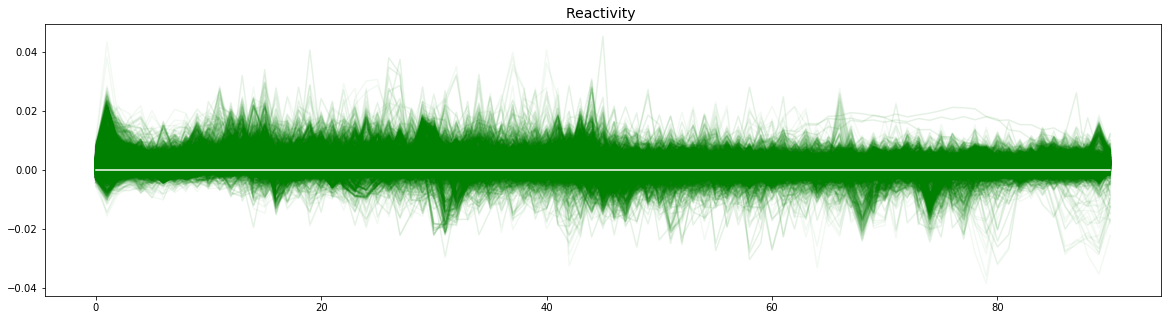

In [31]:
plt.figure(figsize=(20,5))
for i in range(private_preds.shape[0]):
    plt.plot(private_preds[i, :91, 0] - private_predsN[i, :91, 0], color = 'green', alpha = 0.05)
plt.plot([0,90], [0,0], color = 'white')
plt.title('Reactivity ', size = 14)
plt.show()

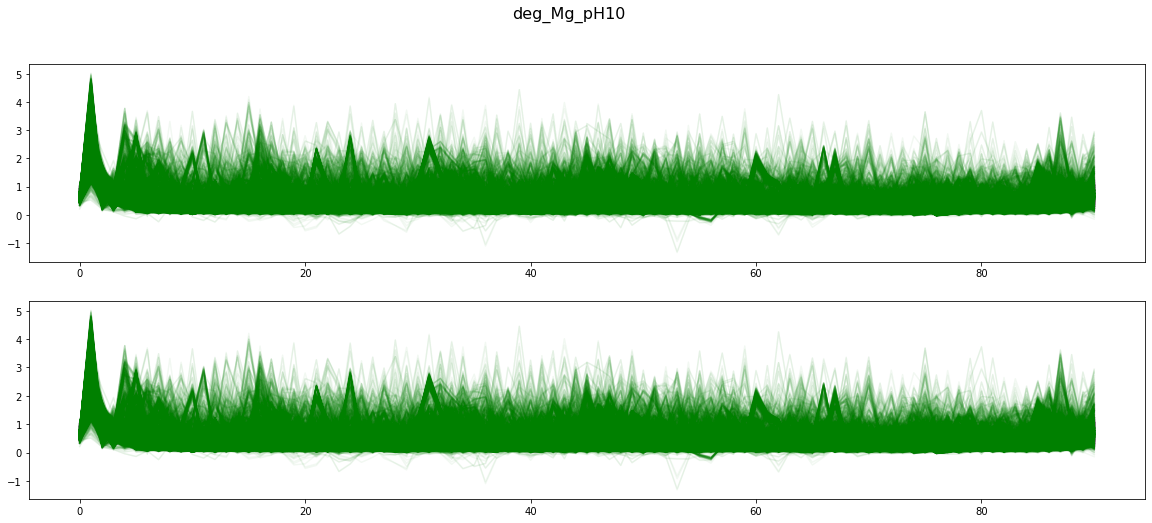

In [32]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20,8))


for i in range(private_preds.shape[0]):
    ax1.plot(np.clip(private_preds[i, :91, 1], -99, 7.5), color = 'green', alpha = 0.05)
    

for i in range(private_preds.shape[0]):
    ax2.plot(private_predsN[i, :91, 1], color = 'green', alpha = 0.05)

fig.suptitle("deg_Mg_pH10", fontsize=16)
fig.show()

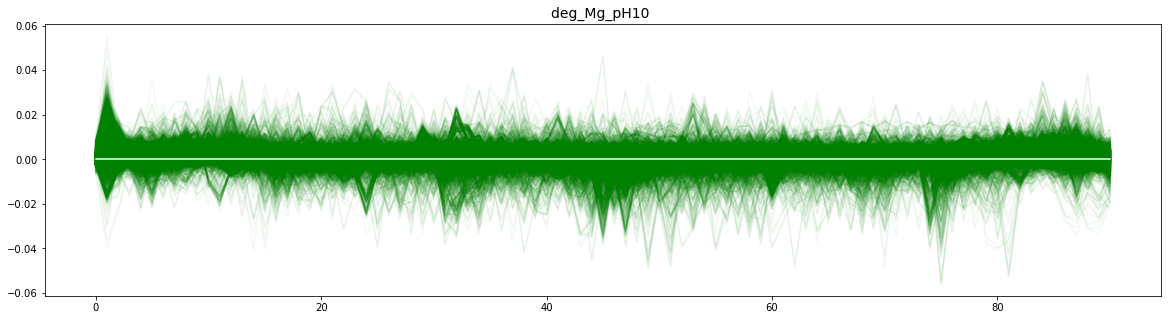

In [33]:
plt.figure(figsize=(20,5))
for i in range(private_preds.shape[0]):
    plt.plot(private_preds[i, :91, 1] - private_predsN[i, :91, 1], color = 'green', alpha = 0.05) 
plt.plot([0,90], [0,0], color = 'white')
plt.title('deg_Mg_pH10 ', size = 14)
plt.show()

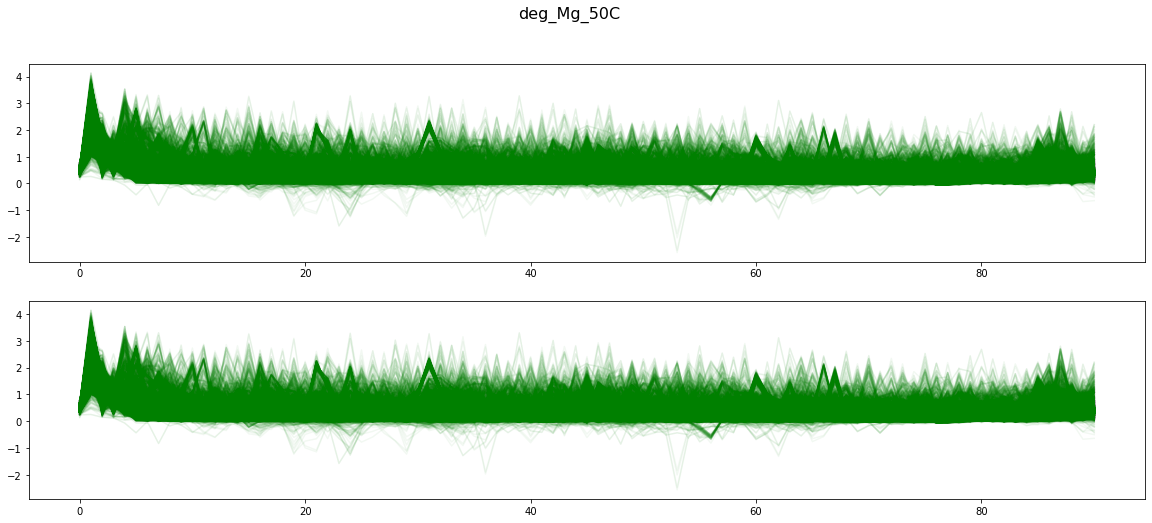

In [34]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20,8))


for i in range(private_preds.shape[0]):
    ax1.plot(np.clip(private_preds[i, :91, 3], -99, 6.0), color = 'green', alpha = 0.05)
    

for i in range(private_preds.shape[0]):
    ax2.plot(private_predsN[i, :91, 3], color = 'green', alpha = 0.05)

fig.suptitle("deg_Mg_50C", fontsize=16)
fig.show()

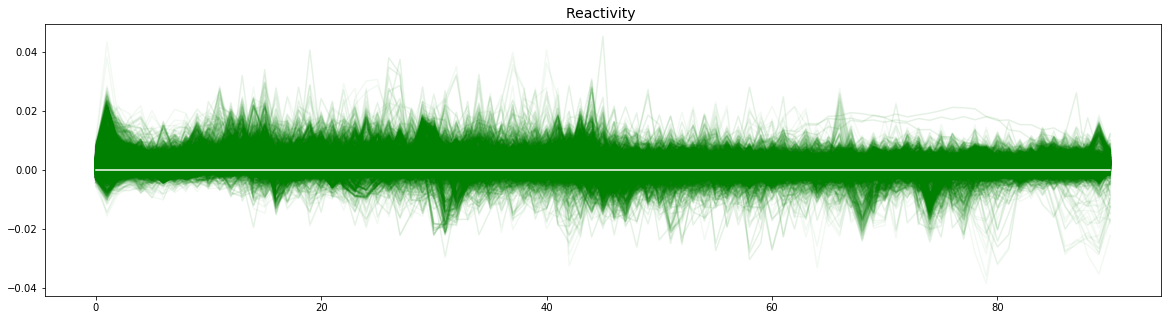

In [35]:
plt.figure(figsize=(20,5))
for i in range(private_preds.shape[0]):
    plt.plot(private_preds[i, :91, 0] - private_predsN[i, :91, 0], color = 'green', alpha = 0.05)
plt.plot([0,90], [0,0], color = 'white')
plt.title('Reactivity ', size = 14)
plt.show()